<a href="https://colab.research.google.com/github/romenlaw/ML-playground/blob/main/ml_playground7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Loading

In [1]:
!rm -f data/*
!wget -nv -P data https://raw.githubusercontent.com/luisguiserrano/manning/master/Chapter_13_End_to_end_example/titanic.csv
!ls -al data
!wc -l data/*.csv

2025-03-27 22:30:47 URL:https://raw.githubusercontent.com/luisguiserrano/manning/master/Chapter_13_End_to_end_example/titanic.csv [61194/61194] -> "data/titanic.csv" [1]
total 68
drwxr-xr-x 2 root root  4096 Mar 27 22:30 .
drwxr-xr-x 1 root root  4096 Mar 27 22:30 ..
-rw-r--r-- 1 root root 61194 Mar 27 22:30 titanic.csv
892 data/titanic.csv


In [2]:
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeRegressor
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
raw_data = pd.read_csv('./data/titanic.csv', index_col='PassengerId')
# note that the PassengerId column is 1-indexed, instead of 0.
# Survived column: 1=servived, 0=not survived
raw_data

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...
887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S


In [4]:
# SibSp - number of siblings / spouses of the passenger travelling onboard
# Parch - number of parent/child of the passenger travelling onboard
raw_data.columns

Index(['Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket',
       'Fare', 'Cabin', 'Embarked'],
      dtype='object')

# Data Cleaning

In [5]:
raw_data.isna().sum(axis=0)

,0
Survived,0
Pclass,0
Name,0
Sex,0
Age,177
SibSp,0
Parch,0
Ticket,0
Fare,0
Cabin,687


In [6]:
# from the above counts we see Cabin has too many missing data (687 out of 891), so drop it
cleaned_data = raw_data.drop('Cabin', axis=1)

# there are 177 records with missing Age values, we can either fill them with
# average or median values. Here we will use median (which happens to be 28)
median_age = cleaned_data['Age'].median()
cleaned_data['Age'] = cleaned_data['Age'].fillna(median_age)

# Embarded is the port of embarkation, having 3 values: C=Cherbourg, Q=Queenstown,
# S=Southhampton. With 2 rows missing the value, we can add new value U=unknown
cleaned_data['Embarked'] = cleaned_data['Embarked'].fillna('U')

# save to file, don't add index column
cleaned_data.to_csv('./data/clean_titanic_data.csv')

# Data PreProcessing

In [7]:
preproc_data = pd.read_csv('./data/clean_titanic_data.csv', index_col='PassengerId')

# turn numerical values into catagorical using one-hot
# gender_cols = pd.get_dummies(preproc_data['Sex'], prefix='Sex')
embarked_cols = pd.get_dummies(preproc_data['Embarked'], prefix='Embarked')

preproc_data = pd.concat([preproc_data, embarked_cols], axis=1)
preproc_data = preproc_data.drop(['Embarked'], axis=1)


Not categorising Sex also seems to improve the performance of SVM.

In [8]:
# Sex only has 2 values, so we can turn them in to 0 and 1 directly
preproc_data['Sex'] = preproc_data['Sex'].astype('category').cat.codes

In [9]:
embarked_cols

,Embarked_C,Embarked_Q,Embarked_S,Embarked_U
PassengerId,,,,
1,False,False,True,False
2,True,False,False,False
3,False,False,True,False
4,False,False,True,False
5,False,False,True,False
...,...,...,...,...
887,False,False,True,False
888,False,False,True,False
889,False,False,True,False


## Rule of thumb to do one-hot or not:

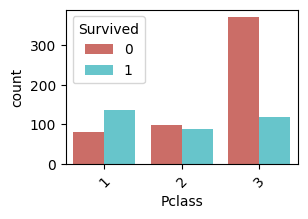

In [10]:
plt.figure(figsize=(3,2))
sns.countplot(x='Pclass', data=preproc_data, palette='hls', hue='Survived')
plt.xticks(rotation=45)
plt.show()

In [11]:
# The Pclass column has 3 values 1,2,3. Should we catagorise it with one-hot?
# If we keep them as-is, the model may assume ordering among them.
# But do they have such order?
pclass_counts = preproc_data['Pclass'].value_counts().rename('pclass_total').sort_index()
pclass_survived_counts = preproc_data[preproc_data['Survived']==1]['Pclass'].value_counts().rename('survive_total').sort_index()
pclass_survived_ratio = (pclass_survived_counts / pclass_counts * 100).rename('survive_ratio(%)').sort_index()

pclass_stats = pd.concat([pclass_counts, pclass_survived_counts, pclass_survived_ratio], axis=1)
print(pclass_stats)

        pclass_total  survive_total  survive_ratio(%)
Pclass                                               
1                216            136         62.962963
2                184             87         47.282609
3                491            119         24.236253


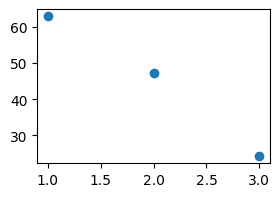

In [12]:
plt.figure(figsize=(3,2))
plt.scatter([1,2,3], pclass_survived_ratio)

seeing above result, there seems to be a linear relationship between the survival rate and the value of the Pclass. So we can keep Pclass as-is.

## Binning
For the Age column we can create bins of 0-10, 11-20, ... and make each bin a catagory using one-hot.

In [13]:
preproc_data['Age'].max()

80.0

In [14]:
bins = [i for i in range(0, 81, 10)] # bin boundries
binned_ages = pd.cut(preproc_data['Age'], bins).rename('Binned_age')
preproc_data = pd.concat([preproc_data,
                          pd.get_dummies(binned_ages, prefix='Binned_age' )],
                         axis=1)
preproc_data = preproc_data.drop(['Age'], axis=1)
preproc_data

,Survived,Pclass,Name,Sex,SibSp,Parch,Ticket,Fare,Embarked_C,Embarked_Q,Embarked_S,Embarked_U,"Binned_age_(0, 10]","Binned_age_(10, 20]","Binned_age_(20, 30]","Binned_age_(30, 40]","Binned_age_(40, 50]","Binned_age_(50, 60]","Binned_age_(60, 70]","Binned_age_(70, 80]"
PassengerId,,,,,,,,,,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",1,1,0,A/5 21171,7.2500,False,False,True,False,False,False,True,False,False,False,False,False
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,1,0,PC 17599,71.2833,True,False,False,False,False,False,False,True,False,False,False,False
3,1,3,"Heikkinen, Miss. Laina",0,0,0,STON/O2. 3101282,7.9250,False,False,True,False,False,False,True,False,False,False,False,False
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,1,0,113803,53.1000,False,False,True,False,False,False,False,True,False,False,False,False
5,0,3,"Allen, Mr. William Henry",1,0,0,373450,8.0500,False,False,True,False,False,False,False,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
887,0,2,"Montvila, Rev. Juozas",1,0,0,211536,13.0000,False,False,True,False,False,False,True,False,False,False,False,False
888,1,1,"Graham, Miss. Margaret Edith",0,0,0,112053,30.0000,False,False,True,False,False,True,False,False,False,False,False,False
889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",0,1,2,W./C. 6607,23.4500,False,False,True,False,False,False,True,False,False,False,False,False


## Drop columns

In [15]:
# passenger name and ticket numbers are unique per record anyway,
# so they can be dropped.
preproc_data = preproc_data.drop(['Name', 'Ticket'], axis=1)

In [16]:
preproc_data

,Survived,Pclass,Sex,SibSp,Parch,Fare,Embarked_C,Embarked_Q,Embarked_S,Embarked_U,"Binned_age_(0, 10]","Binned_age_(10, 20]","Binned_age_(20, 30]","Binned_age_(30, 40]","Binned_age_(40, 50]","Binned_age_(50, 60]","Binned_age_(60, 70]","Binned_age_(70, 80]"
PassengerId,,,,,,,,,,,,,,,,,,
1,0,3,1,1,0,7.2500,False,False,True,False,False,False,True,False,False,False,False,False
2,1,1,0,1,0,71.2833,True,False,False,False,False,False,False,True,False,False,False,False
3,1,3,0,0,0,7.9250,False,False,True,False,False,False,True,False,False,False,False,False
4,1,1,0,1,0,53.1000,False,False,True,False,False,False,False,True,False,False,False,False
5,0,3,1,0,0,8.0500,False,False,True,False,False,False,False,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
887,0,2,1,0,0,13.0000,False,False,True,False,False,False,True,False,False,False,False,False
888,1,1,0,0,0,30.0000,False,False,True,False,False,True,False,False,False,False,False,False
889,0,3,0,1,2,23.4500,False,False,True,False,False,False,True,False,False,False,False,False


Scaling the data actually makes SVM perform the best (with 84% accuracy). So skip it to be consistent with the book.

In [17]:
# scale the numeric column(s)
import os
from sklearn.preprocessing import StandardScaler

# from keras.wrappers.scikit_learn import KerasClassifier
# from keras.models import Sequential
# from keras.layers import Dense, Activation, Dropout
continuous = ['Fare', 'Parch', 'Pclass', 'SibSp']

scaler = StandardScaler()

# for var in continuous:
#   preproc_data[var] = preproc_data[var].astype('float64')
#   preproc_data[var] = scaler.fit_transform(preproc_data[var].values.reshape(-1,1))

# preproc_data

In [18]:
# index=None drops the passengerId which is index col
preproc_data.to_csv('./data/preprocessed_titanic_data.csv', index=None)

# Training Model

## Splitting dataset

In [19]:
data = pd.read_csv('./data/preprocessed_titanic_data.csv')
data

,Survived,Pclass,Sex,SibSp,Parch,Fare,Embarked_C,Embarked_Q,Embarked_S,Embarked_U,"Binned_age_(0, 10]","Binned_age_(10, 20]","Binned_age_(20, 30]","Binned_age_(30, 40]","Binned_age_(40, 50]","Binned_age_(50, 60]","Binned_age_(60, 70]","Binned_age_(70, 80]"
0,0,3,1,1,0,7.2500,False,False,True,False,False,False,True,False,False,False,False,False
1,1,1,0,1,0,71.2833,True,False,False,False,False,False,False,True,False,False,False,False
2,1,3,0,0,0,7.9250,False,False,True,False,False,False,True,False,False,False,False,False
3,1,1,0,1,0,53.1000,False,False,True,False,False,False,False,True,False,False,False,False
4,0,3,1,0,0,8.0500,False,False,True,False,False,False,False,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,2,1,0,0,13.0000,False,False,True,False,False,False,True,False,False,False,False,False
887,1,1,0,0,0,30.0000,False,False,True,False,False,True,False,False,False,False,False,False
888,0,3,0,1,2,23.4500,False,False,True,False,False,False,True,False,False,False,False,False
889,1,1,1,0,0,30.0000,True,False,False,False,False,False,True,False,False,False,False,False


In [20]:
features = data.drop(['Survived'], axis=1)
labels = data['Survived']

In [21]:
from sklearn.model_selection import train_test_split

# want 60% training, 20% validation, 20% testing
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.4)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5)

In [22]:
X_train.shape, X_test.shape, X_val.shape, y_train.shape, y_test.shape, y_val.shape

((534, 17), (179, 17), (178, 17), (534,), (179,), (178,))

## Train several models
We'll train four models:

* Logistic regression (perceptron)
* Decision tree
* Naive Bayes
* Support vector machine (SVM)

In [23]:
from sklearn.linear_model import LogisticRegression

lr_model = LogisticRegression()
lr_model.fit(X_train, y_train)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [24]:
from sklearn.tree import DecisionTreeClassifier

dt_model = DecisionTreeClassifier()
dt_model.fit(X_train, y_train)

DecisionTreeClassifier()

In [25]:
from sklearn.naive_bayes import GaussianNB

nb_model = GaussianNB()
nb_model.fit(X_train, y_train)

GaussianNB()

In [26]:
from sklearn.svm import SVC

svm_model = SVC()
svm_model.fit(X_train, y_train)

SVC()

In [27]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier

rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)

gb_model = GradientBoostingClassifier()
gb_model.fit(X_train, y_train)

ab_model = AdaBoostClassifier()
ab_model.fit(X_train, y_train)

AdaBoostClassifier()

In [28]:
models = [lr_model, dt_model, nb_model, svm_model, rf_model, gb_model, ab_model]

## Evaluating models

**Accuracy** = no. of correct pred / total no. of data points

**Recall** = TP / (TP+FN).

**Precision** = TP / (TP+FP)

**F1-score** = harmonic mean of precision and recall (i.e. a number between those two values but closer to the smaller one).

In [29]:
type(lr_model).__name__

'LogisticRegression'

In [30]:
from sklearn.metrics import f1_score, recall_score, precision_score

names = []
accuracies = []
f1_scores = []
precisions = []
recalls = []

for model in models:
  name = type(model).__name__
  accuracy = model.score(X_val, y_val)
  y_hat = model.predict(X_val)
  precision = precision_score(y_val, y_hat)
  recall = recall_score(y_val, y_hat)
  f1 = f1_score(y_val, y_hat)

  names.append(name)
  accuracies.append(accuracy)
  f1_scores.append(f1)
  precisions.append(precision)
  recalls.append(recall)

df_models_val = pd.DataFrame(
    {
        'Model': names,
        'Accuracy': accuracies,
        'F1 score': f1_scores,
        'Precision': precisions,
        'Recall': recalls,
    }
)
df_models_val.sort_values(['Accuracy'], ascending=False)

,Model,Accuracy,F1 score,Precision,Recall
5,GradientBoostingClassifier,0.831461,0.732143,0.773585,0.694915
4,RandomForestClassifier,0.825843,0.725664,0.759259,0.694915
1,DecisionTreeClassifier,0.786517,0.683333,0.672131,0.694915
6,AdaBoostClassifier,0.769663,0.637168,0.666667,0.610169
0,LogisticRegression,0.769663,0.643478,0.660714,0.627119
2,GaussianNB,0.674157,0.236842,0.529412,0.152542
3,SVC,0.674157,0.340909,0.517241,0.254237


## Testing models

In [31]:
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score

names = []
accuracies = []
f1_scores = []
precisions = []
recalls = []

for model in models:
  name = type(model).__name__
  y_hat = model.predict(X_test)
  accuracy = accuracy_score(y_test, y_hat)
  precision = precision_score(y_test, y_hat)
  recall = recall_score(y_test, y_hat)
  f1 = f1_score(y_test, y_hat)

  names.append(name)
  accuracies.append(accuracy)
  f1_scores.append(f1)
  precisions.append(precision)
  recalls.append(recall)

df_models_test = pd.DataFrame(
    {
        'Model': names,
        'Accuracy': accuracies,
        'F1 score': f1_scores,
        'Precision': precisions,
        'Recall': recalls,
    }
)
df_models_test.sort_values(['Accuracy'], ascending=False)

,Model,Accuracy,F1 score,Precision,Recall
0,LogisticRegression,0.837989,0.775194,0.781250,0.769231
5,GradientBoostingClassifier,0.826816,0.766917,0.750000,0.784615
6,AdaBoostClassifier,0.810056,0.750000,0.718310,0.784615
4,RandomForestClassifier,0.804469,0.748201,0.702703,0.800000
1,DecisionTreeClassifier,0.798883,0.746479,0.688312,0.815385
2,GaussianNB,0.715084,0.413793,0.818182,0.276923
3,SVC,0.715084,0.495050,0.694444,0.384615


## Hyperparam tuning with GridSearch

GridSearchCV where CV stands for Cross-Validation. The *k-fold cross validation* is an alternative to training-validation-testing method. It allows the same dataset to be used for training, validation:
1. split data into k equal portions
2. use the *k*th portion as the validation set, the rest as the training set.
3. the final score = average of all the k scores. i.e. $\frac{1}{k}\sum_{i=1}^{k}{score_i}$

In [32]:
from sklearn.model_selection import GridSearchCV

svm_params = {
    'kernel': ['rbf'],
    'C': [0.01, .1, 1, 10, 100],
    'gamma': [.01, .1, 1, 10, 100],
}
svm = SVC()
svm_gs = GridSearchCV(estimator = svm, param_grid=svm_params)
svm_gs.fit(X_train, y_train)

svm_winner = svm_gs.best_estimator_
svm_winner.score(X_val, y_val)

0.7471910112359551

In [33]:
svm_winner

SVC(C=10, gamma=0.01)

In [34]:
svm_gs.cv_results_

{'mean_fit_time': array([0.04962974, 0.02035394, 0.02342997, 0.02532806, 0.04248548,
        0.01971025, 0.02052145, 0.02519836, 0.02339182, 0.03315501,
        0.02520356, 0.0286314 , 0.03662257, 0.04702206, 0.03361335,
        0.02158556, 0.04756327, 0.0395082 , 0.03680096, 0.04653578,
        0.04951577, 0.06716118, 0.04112897, 0.05516458, 0.05829921]),
 'std_fit_time': array([0.02664595, 0.00407491, 0.0052692 , 0.00417739, 0.01822952,
        0.00492116, 0.00802628, 0.00999014, 0.00495995, 0.01068044,
        0.00701996, 0.00859776, 0.0136854 , 0.01677273, 0.01006009,
        0.00178651, 0.02062997, 0.01196712, 0.01671644, 0.02221148,
        0.01430687, 0.0318781 , 0.03021368, 0.02481894, 0.00966087]),
 'mean_score_time': array([0.02718778, 0.01063504, 0.00925784, 0.01411257, 0.0129209 ,
        0.01004643, 0.00842924, 0.01123881, 0.01522188, 0.01300921,
        0.01008306, 0.01197085, 0.01534615, 0.02065773, 0.02193699,
        0.00838747, 0.01541057, 0.01759129, 0.01658149, 0.02